# Preprocessing Sentinel Images

Notebook contains code for splitting images of sentinel dataset

In [ ]:
%pip install rasterio

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import os, sys
import tarfile

from rasterio.windows import Window
from PIL import Image
from tqdm import tqdm

In [ ]:
project_root = os.getenv('PROJECT_ROOT_PATH')
data_save_path = os.getenv('DATA_PATH')
data_save_path = os.getenv('DATA_PATH')

# Add the project root path to the system path
sys.path.append(project_root)

#necessary imports
from scripts.data_preparation.splitting import *
from scripts.data_preparation.masks_creation import *

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) ##force_remount=True

Mounted at /content/drive


#### Splitting images that didn't require masks modification

In [ ]:
main_path = os.path.join(data_save_path, 'SENTINEL/RAW/')  
quarter = 'waterbodies_data_Q4_2024_raw/OK/'
output_dir = os.path.join(data_save_path, 'SENTINE_PROCESSED')

In [ ]:
i = 0

for id in os.listdir(main_path+ quarter):

  print("processing", id, i, "out of", len(os.listdir(main_path+ quarter)))
  i+=1

  bands = read_dataset_tar(main_path + quarter + id + '/response.tar')
  rgb_scaled = create_rgb(bands['rgb_nir'][:3])
 
  ndwi_img = create_ndwi(bands['green_band'], bands['nir_band'])
  ndwi_mask = create_ndwi_mask(ndwi_img)

  mask = final_mask(bands['scl_band'],bands['cld_band'], 15, rgb_scaled, ndwi_mask)

  save_tiled_chunks(bands,mask,output_dir +quarter+ id)

#### Splitting images that required masks modification

In [ ]:
main_path = os.path.join(data_save_path, 'SENTINEL/RAW/')  
quarter = 'waterbodies_data_Q4_2024_raw/Modify/'
output_dir = os.path.join(data_save_path, 'SENTINEL_PROCESSED')

In [ ]:
process_all_npy_and_tar_pairs(modify_folder=main_path+quarter,output_root=output_dir+quarter)

Processing folder: 14bbe20e0933d9595c86cbaae9dab737


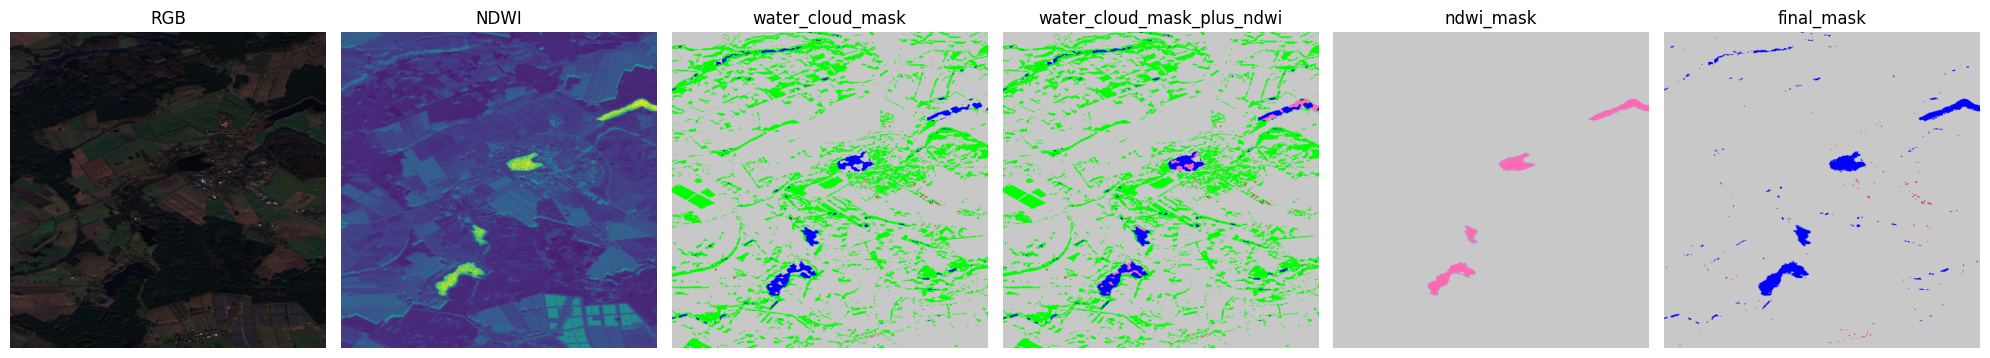

In [ ]:
data_path = main_path + "data_Q1_2022_raw/Modify"

stats = {'n_with_cloud':0,'n_with_water':0,'n_with_both':0, 'n_with_nothing':0}


for folder_name in os.listdir(data_path)[1:2]:
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):  
        print(f"Processing folder: {folder_name}")
        file_name = '/response.tar' 
        file_path = folder_path + file_name
        if os.path.exists(file_path):

            data_dict = read_dataset_tar(file_path)

            rgb_scaled = create_rgb(data_dict['rgb_nir'][:3])
            ndwi_img = create_ndwi(data_dict['green_band'], data_dict['nir_band'])
            ndwi_mask = create_ndwi_mask(ndwi_img)
            scl_mask = create_scl_masks(data_dict['scl_band'])
            mask = create_combined_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled)
            mask_extended = create_combined_mask_with_ndwi(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask)
            final = final_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask)

            visualize_images(rgb_scaled, ndwi_img,  mask, mask_extended, ndwi_mask, final)


        else:
            print(f"response.tiff not found in {folder_path}")
    else:
        print(f"Skipping {folder_name}, it's not a directory")


Found 64 image–mask pairs


<ipython-input-36-5776cc48af0a>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)  # background, water, cloud


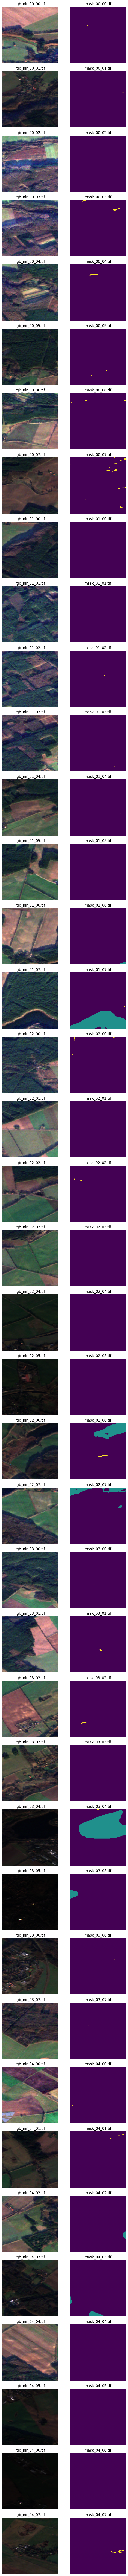

In [ ]:
#Check parts of one image

data_path = output_dir + "/data_Q1_2022_raw/Modify/14bbe20e0933d9595c86cbaae9dab737"


pairs = []

for file in os.listdir(data_path):

    if file.startswith("rgb_nir_") and file.endswith(".tif"):
        tile_id = file[len("rgb_nir_"):-len(".tif")]
        mask_file = f"mask_{tile_id}.tif"
        mask_path = os.path.join(data_path, mask_file)
        img_path = os.path.join(data_path, file)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))

print(f"Found {len(pairs)} image–mask pairs")

n = min(40, len(pairs))
plt.figure(figsize=(7, 3 * n))

for i, (img_path, mask_path) in enumerate(pairs[:n]):
    with rasterio.open(img_path) as img_src:
        rgb = img_src.read([1, 2, 3])  
        rgb = np.transpose(rgb, (1, 2, 0)) 
        rgb = (rgb - np.min(rgb)) / (np.ptp(rgb) + 1e-6)

    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)

    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(rgb)
    plt.title(os.path.basename(img_path))
    plt.axis('off')

    plt.subplot(n, 2, 2 * i + 2)
    cmap = plt.cm.get_cmap('viridis', 3) 
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=2)
    plt.title(os.path.basename(mask_path))
    plt.axis('off')

plt.tight_layout()
plt.show()


<ipython-input-2-23eda1def41b>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)


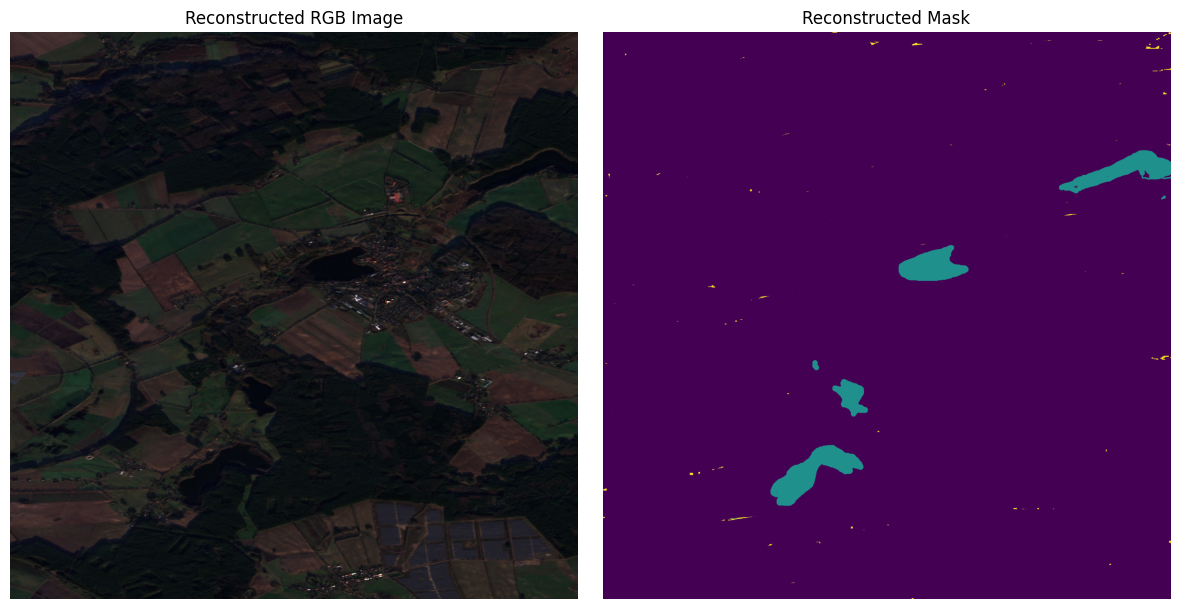

In [ ]:
data_path = output_dir + "/data_Q1_2022_raw/Modify/14bbe20e0933d9595c86cbaae9dab737"

visualize_tiled_image_and_mask(data_path)